In [ ]:
!uv pip install datasets pylate

Using Python 3.12.12 environment at: /usr
Resolved 74 packages in 1.20s
Prepared 9 packages in 568ms
Uninstalled 2 packages in 357ms
Installed 10 packages in 71ms
 + fast-plaid==1.2.4.280
 + fastkmeans==0.5.0
 + maturin==1.9.6
 + ninja==1.11.1.4
 + pylate==1.3.4
 - setuptools==75.2.0
 + setuptools==80.9.0
 + sqlitedict==2.1.0
 - transformers==4.57.1
 + transformers==4.56.2
 + ujson==5.10.0
 + voyager==2.1.0


In [ ]:
import argparse
import gzip
import json
import logging
import os
import pickle
import random
import tarfile
from datetime import datetime
from datasets import load_dataset, Dataset
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader

from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, SequentialEvaluator,TripletEvaluator
from sentence_transformers.training_args import BatchSamplers

from sentence_transformers import InputExample, LoggingHandler, SentenceTransformer, losses, models, util

#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
#### /print debug information to stdout

In [ ]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `full` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate whe

In [ ]:
!uv pip install beir pylate ranx

Using Python 3.12.12 environment at: /usr
Resolved 108 packages in 1.07s
Prepared 15 packages in 1.25s
Installed 15 packages in 7ms
 + beir==2.2.0
 + cbor==1.0.0
 + cbor2==5.7.0
 + fastparquet==2024.11.0
 + ijson==3.4.0.post0
 + inscriptis==2.6.0
 + ir-datasets==0.5.11
 + lz4==4.4.4
 + pytrec-eval-terrier==0.5.10
 + ranx==0.3.21
 + trec-car-tools==2.6
 + unlzw3==0.2.3
 + warc3-wet==0.2.5
 + warc3-wet-clueweb09==0.2.5
 + zlib-state==0.1.10


#**col-ettin-encoder-150M-TR**

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/col-ettin-encoder-150M-TR",
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

corpus/corpus-00000-of-00001.parquet:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/8674 [00:00<?, ? examples/s]

queries/queries-00000-of-00001.parquet:   0%|          | 0.00/949k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/1406 [00:00<?, ? examples/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1406 [00:00<?, ? examples/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:202: SyntaxWarning: invalid escape sequence '\c'
  + """\\begin{table*}[ht]\n\centering\n\caption{\nOverall effectiveness of the models.\nThe best results are highlighted in boldface.\nSuperscripts denote significant differences in """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:204: SyntaxWarning: invalid escape sequence '\l'
  + """ with $p \le """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:211: SyntaxWarning: invalid escape sequence '\#'
  + "\n\\textbf{\#}"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:216: SyntaxWarning: invalid escape sequence '\m'
  + " \\\\ \n\midrule"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:246: SyntaxWarning: invalid escape sequence '\e'
  "\\bottomrule\n\end{tabular}\n}\n\label{tab:results}\n\end{table*}"
/usr/local/lib/python3.12/dist-packages/ranx/metrics/ndcg.py:72: NumbaTypeS

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.11515839749289122), 'ndcg@5': np.float64(0.14953211086782792), 'ndcg@10': np.float64(0.18058072753238874), 'ndcg@100': np.float64(0.23594887355700858), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.19772403982930298), 'hits@5': np.float64(0.2809388335704125), 'hits@10': np.float64(0.37766714082503555), 'hits@100': np.float64(0.6422475106685633), 'map': np.float64(0.12931257683267353), 'recall@10': np.float64(0.37766714082503555), 'recall@100': np.float64(0.6422475106685633), 'precision@10': np.float64(0.03776671408250356), 'precision@100': np.float64(0.006422475106685634)}


#**col**-ettin-encoder-32M-TR

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/col-ettin-encoder-32M-TR",
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/128M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.1087066499517408), 'ndcg@5': np.float64(0.13564609110359946), 'ndcg@10': np.float64(0.16561018270235878), 'ndcg@100': np.float64(0.22464669694350092), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.18705547652916074), 'hits@5': np.float64(0.25177809388335703), 'hits@10': np.float64(0.3456614509246088), 'hits@100': np.float64(0.6287339971550497), 'map': np.float64(0.1204503481977881), 'recall@10': np.float64(0.3456614509246088), 'recall@100': np.float64(0.6287339971550497), 'precision@10': np.float64(0.03456614509246088), 'precision@100': np.float64(0.0062873399715504975)}


#**colbert**-nano-tr

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/colbert-nano-tr",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

configuration_bert_hash.py:   0%|          | 0.00/340 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-nano-tr:
- configuration_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert_hash.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-nano-tr:
- modeling_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

1_Dense/model.safetensors:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.09068885724192544), 'ndcg@5': np.float64(0.11677169656409526), 'ndcg@10': np.float64(0.14532336522965159), 'ndcg@100': np.float64(0.1939135525849379), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.15362731152204837), 'hits@5': np.float64(0.21621621621621623), 'hits@10': np.float64(0.30440967283072545), 'hits@100': np.float64(0.5405405405405406), 'map': np.float64(0.10455618808324911), 'recall@10': np.float64(0.30440967283072545), 'recall@100': np.float64(0.5405405405405406), 'precision@10': np.float64(0.030440967283072544), 'precision@100': np.float64(0.005405405405405406)}


#**colbert-hash-pico-tr**

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/colbert-hash-pico-tr",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

configuration_bert_hash.py:   0%|          | 0.00/340 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-hash-pico-tr:
- configuration_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert_hash.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-hash-pico-tr:
- modeling_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

1_Dense/model.safetensors:   0%|          | 0.00/41.0k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.08558333250355907), 'ndcg@5': np.float64(0.10933496385165573), 'ndcg@10': np.float64(0.13528799441271078), 'ndcg@100': np.float64(0.18364700392179717), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.14509246088193456), 'hits@5': np.float64(0.20270270270270271), 'hits@10': np.float64(0.283072546230441), 'hits@100': np.float64(0.5213371266002845), 'map': np.float64(0.0977174947914049), 'recall@10': np.float64(0.283072546230441), 'recall@100': np.float64(0.5213371266002845), 'precision@10': np.float64(0.028307254623044096), 'precision@100': np.float64(0.005213371266002845)}


#**colbert**-femto-tr

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/colbert-femto-tr",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

configuration_bert_hash.py:   0%|          | 0.00/340 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-femto-tr:
- configuration_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert_hash.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ozayezerceli/colbert-femto-tr:
- modeling_bert_hash.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/975k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

1_Dense/model.safetensors:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0035561877667140826), 'ndcg@3': np.float64(0.03415559648953559), 'ndcg@5': np.float64(0.04560311124873952), 'ndcg@10': np.float64(0.05760785560979691), 'ndcg@100': np.float64(0.09296765235275792), 'hits@1': np.float64(0.0035561877667140826), 'hits@3': np.float64(0.0561877667140825), 'hits@5': np.float64(0.08392603129445235), 'hits@10': np.float64(0.12091038406827881), 'hits@100': np.float64(0.29445234708392604), 'map': np.float64(0.04442420674316565), 'recall@10': np.float64(0.12091038406827881), 'recall@100': np.float64(0.29445234708392604), 'precision@10': np.float64(0.01209103840682788), 'precision@100': np.float64(0.002944523470839261)}


#**ColmmBert**-base-TR

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/ColmmBERT-base-TR",
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

modules.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/771 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

1_Dense/model.safetensors:   0%|          | 0.00/393k [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.15648507604146025), 'ndcg@5': np.float64(0.19967416049188455), 'ndcg@10': np.float64(0.24475564082874834), 'ndcg@100': np.float64(0.30317951970079804), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.2652916073968706), 'hits@5': np.float64(0.36984352773826457), 'hits@10': np.float64(0.5078236130867709), 'hits@100': np.float64(0.7844950213371266), 'map': np.float64(0.17329776911837286), 'recall@10': np.float64(0.5078236130867709), 'recall@100': np.float64(0.7844950213371266), 'precision@10': np.float64(0.0507823613086771), 'precision@100': np.float64(0.007844950213371267)}


#**ColmmBert-small-TR**

In [ ]:
import pandas as pd
import numpy as np

# Extract metrics from cell outputs
metrics_150M = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.11515839749289122), 'ndcg@5': np.float64(0.14953211086782792), 'ndcg@10': np.float64(0.18058072753238874), 'ndcg@100': np.float64(0.23594887355700858), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.19772403982930298), 'hits@5': np.float64(0.2809388335704125), 'hits@10': np.float64(0.37766714082503555), 'hits@100': np.float64(0.6422475106685633), 'map': np.float64(0.12931257683267353), 'recall@10': np.float64(0.37766714082503555), 'recall@100': np.float64(0.6422475106685633), 'precision@10': np.float64(0.03776671408250356), 'precision@100': np.float64(0.006422475106685634)}
metrics_32M = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.1087066499517408), 'ndcg@5': np.float64(0.13564609110359946), 'ndcg@10': np.float64(0.16561018270235878), 'ndcg@100': np.float64(0.22464669694350092), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.18705547652916074), 'hits@5': np.float64(0.25177809388335703), 'hits@10': np.float64(0.3456614509246088), 'hits@100': np.float64(0.6287339971550497), 'map': np.float64(0.1204503481977881), 'recall@10': np.float64(0.3456614509246088), 'recall@100': np.float64(0.6287339971550497), 'precision@10': np.float64(0.03456614509246088), 'precision@100': np.float64(0.0062873399715504975)}
metrics_nano = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.09068885724192544), 'ndcg@5': np.float64(0.11677169656409526), 'ndcg@10': np.float64(0.14532336522965159), 'ndcg@100': np.float64(0.1939135525849379), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.15362731152204837), 'hits@5': np.float64(0.21621621621621623), 'hits@10': np.float64(0.30440967283072545), 'hits@100': np.float64(0.5405405405405406), 'map': np.float64(0.10455618808324911), 'recall@10': np.float64(0.30440967283072545), 'recall@100': np.float64(0.5405405405405406), 'precision@10': np.float64(0.030440967283072544), 'precision@100': np.float64(0.005405405405405406)}
metrics_pico = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.08558333250355907), 'ndcg@5': np.float64(0.10933496385165573), 'ndcg@10': np.float64(0.13528799441271078), 'ndcg@100': np.float64(0.18364700392179717), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.14509246088193456), 'hits@5': np.float64(0.20270270270270271), 'hits@10': np.float64(0.283072546230441), 'hits@100': np.float64(0.5213371266002845), 'map': np.float64(0.0977174947914049), 'recall@10': np.float64(0.283072546230441), 'recall@100': np.float64(0.5213371266002845), 'precision@10': np.float64(0.028307254623044096), 'precision@100': np.float64(0.005213371266002845)}
metrics_femto = {'ndcg@1': np.float64(0.0035561877667140826), 'ndcg@3': np.float64(0.03415559648953559), 'ndcg@5': np.float64(0.04560311124873952), 'ndcg@10': np.float64(0.05760785560979691), 'ndcg@100': np.float64(0.09296765235275792), 'hits@1': np.float64(0.0035561877667140826), 'hits@3': np.float64(0.0561877667140825), 'hits@5': np.float64(0.08392603129445235), 'hits@10': np.float64(0.12091038406827881), 'hits@100': np.float64(0.29445234708392604), 'map': np.float64(0.04442420674316565), 'recall@10': np.float64(0.12091038406827881), 'recall@100': np.float64(0.29445234708392604), 'precision@10': np.float64(0.01209103840682788), 'precision@100': np.float64(0.002944523470839261)}
metrics_ColmmBERT_base = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.15648507604146025), 'ndcg@5': np.float64(0.19967416049188455), 'ndcg@10': np.float64(0.24475564082874834), 'ndcg@100': np.float64(0.30317951970079804), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.2652916073968706), 'hits@5': np.float64(0.36984352773826457), 'hits@10': np.float64(0.5078236130867709), 'hits@100': np.float64(0.7844950213371266), 'map': np.float64(0.17329776911837286), 'recall@10': np.float64(0.5078236130867709), 'recall@100': np.float64(0.7844950213371266), 'precision@10': np.float64(0.0507823613086771), 'precision@100': np.float64(0.007844950213371267)}
metrics_ColmmBERT_small = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.1469177847033169), 'ndcg@5': np.float64(0.18526819388525145), 'ndcg@10': np.float64(0.22486304662494835), 'ndcg@100': np.float64(0.2858714236246463), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.2524893314366999), 'hits@5': np.float64(0.3456614509246088), 'hits@10': np.float64(0.46799431009957326), 'hits@100': np.float64(0.7588904694167852), 'map': np.float64(0.1601112313017649), 'recall@10': np.float64(0.46799431009957326), 'recall@100': np.float64(0.7588904694167852), 'precision@10': np.float64(0.04679943100995732), 'precision@100': np.float64(0.007588904694167852)}
metrics_TurkEmbed4Retrieval = {'ndcg@1': np.float64(0.012802275960170697), 'ndcg@3': np.float64(0.15410641254064666), 'ndcg@5': np.float64(0.1974459648458925), 'ndcg@10': np.float64(0.2446567125767366), 'ndcg@100': np.float64(0.3079948259007796), 'hits@1': np.float64(0.012802275960170697), 'hits@3': np.float64(0.2546230440967283), 'hits@5': np.float64(0.35988620199146515), 'hits@10': np.float64(0.5064011379800853), 'hits@100': np.float64(0.802275960170697), 'map': np.float64(0.1758823838458061), 'recall@10': np.float64(0.5064011379800853), 'recall@100': np.float64(0.802275960170697), 'precision@10': np.float64(0.05064011379800853), 'precision@100': np.float64(0.00802275960170697)}
metrics_turkish_colbert = {'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.12493757588905097), 'ndcg@5': np.float64(0.1638382735592281), 'ndcg@10': np.float64(0.2071314772619379), 'ndcg@100': np.float64(0.2680853969350127), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.21337126600284495), 'hits@5': np.float64(0.3079658605974395), 'hits@10': np.float64(0.44096728307254623), 'hits@100': np.float64(0.7347083926031295), 'map': np.float64(0.14571665693698688), 'recall@10': np.float64(0.44096728307254623), 'recall@100': np.float64(0.7347083926031295), 'precision@10': np.float64(0.044096728307254626), 'precision@100': np.float64(0.007347083926031293)}
metrics_e5_large = {'ndcg@1': np.float64(0.019203413940256046), 'ndcg@3': np.float64(0.1597963129673892), 'ndcg@5': np.float64(0.20310469617531016), 'ndcg@10': np.float64(0.24586267633936687), 'ndcg@100': np.float64(0.3059083911202854), 'hits@1': np.float64(0.019203413940256046), 'hits@3': np.float64(0.259601706970128), 'hits@5': np.float64(0.36486486486486486), 'hits@10': np.float64(0.4971550497866287), 'hits@100': np.float64(0.7802275960170697), 'map': np.float64(0.1791329528385223), 'recall@10': np.float64(0.4971550497866287), 'recall@100': np.float64(0.7802275960170697), 'precision@10': np.float64(0.04971550497866288), 'precision@100': np.float64(0.007802275960170697)}


data = {
    "Model": ["col-ettin-encoder-150M-TR", "col-ettin-encoder-32M-TR", "colbert-nano-tr", "colbert-hash-pico-tr", "colbert-femto-tr", "ColmmBERT-base-TR", "ColmmBERT-small-TR", "TurkEmbed4Retrieval", "ytu-ce-cosmos/turkish-colbert", "ytu-ce-cosmos/turkish-e5-large"],
    "ndcg@1": [metrics_150M['ndcg@1'], metrics_32M['ndcg@1'], metrics_nano['ndcg@1'], metrics_pico['ndcg@1'], metrics_femto['ndcg@1'], metrics_ColmmBERT_base['ndcg@1'], metrics_ColmmBERT_small['ndcg@1'], metrics_TurkEmbed4Retrieval['ndcg@1'], metrics_turkish_colbert['ndcg@1'], metrics_e5_large['ndcg@1']],
    "ndcg@3": [metrics_150M['ndcg@3'], metrics_32M['ndcg@3'], metrics_nano['ndcg@3'], metrics_pico['ndcg@3'], metrics_femto['ndcg@3'], metrics_ColmmBERT_base['ndcg@3'], metrics_ColmmBERT_small['ndcg@3'], metrics_TurkEmbed4Retrieval['ndcg@3'], metrics_turkish_colbert['ndcg@3'], metrics_e5_large['ndcg@3']],
    "ndcg@5": [metrics_150M['ndcg@5'], metrics_32M['ndcg@5'], metrics_nano['ndcg@5'], metrics_pico['ndcg@5'], metrics_femto['ndcg@5'], metrics_ColmmBERT_base['ndcg@5'], metrics_ColmmBERT_small['ndcg@5'], metrics_TurkEmbed4Retrieval['ndcg@5'], metrics_turkish_colbert['ndcg@5'], metrics_e5_large['ndcg@5']],
    "ndcg@10": [metrics_150M['ndcg@10'], metrics_32M['ndcg@10'], metrics_nano['ndcg@10'], metrics_pico['ndcg@10'], metrics_femto['ndcg@10'], metrics_ColmmBERT_base['ndcg@10'], metrics_ColmmBERT_small['ndcg@10'], metrics_TurkEmbed4Retrieval['ndcg@10'], metrics_turkish_colbert['ndcg@10'], metrics_e5_large['ndcg@10']],
    "ndcg@100": [metrics_150M['ndcg@100'], metrics_32M['ndcg@100'], metrics_nano['ndcg@100'], metrics_pico['ndcg@100'], metrics_femto['ndcg@100'], metrics_ColmmBERT_base['ndcg@100'], metrics_ColmmBERT_small['ndcg@100'], metrics_TurkEmbed4Retrieval['ndcg@100'], metrics_turkish_colbert['ndcg@100'], metrics_e5_large['ndcg@100']],
    "hits@1": [metrics_150M['hits@1'], metrics_32M['hits@1'], metrics_nano['hits@1'], metrics_pico['hits@1'], metrics_femto['hits@1'], metrics_ColmmBERT_base['hits@1'], metrics_ColmmBERT_small['hits@1'], metrics_TurkEmbed4Retrieval['hits@1'], metrics_turkish_colbert['hits@1'], metrics_e5_large['hits@1']],
    "hits@3": [metrics_150M['hits@3'], metrics_32M['hits@3'], metrics_nano['hits@3'], metrics_pico['hits@3'], metrics_femto['hits@3'], metrics_ColmmBERT_base['hits@3'], metrics_ColmmBERT_small['hits@3'], metrics_TurkEmbed4Retrieval['hits@3'], metrics_turkish_colbert['hits@3'], metrics_e5_large['hits@3']],
    "hits@5": [metrics_150M['hits@5'], metrics_32M['hits@5'], metrics_nano['hits@5'], metrics_pico['hits@5'], metrics_femto['hits@5'], metrics_ColmmBERT_base['hits@5'], metrics_ColmmBERT_small['hits@5'], metrics_TurkEmbed4Retrieval['hits@5'], metrics_turkish_colbert['hits@5'], metrics_e5_large['hits@5']],
    "hits@10": [metrics_150M['hits@10'], metrics_32M['hits@10'], metrics_nano['hits@10'], metrics_pico['hits@10'], metrics_femto['hits@10'], metrics_ColmmBERT_base['hits@10'], metrics_ColmmBERT_small['hits@10'], metrics_TurkEmbed4Retrieval['hits@10'], metrics_turkish_colbert['hits@10'], metrics_e5_large['hits@10']],
    "hits@100": [metrics_150M['hits@100'], metrics_32M['hits@100'], metrics_nano['hits@100'], metrics_pico['hits@100'], metrics_femto['hits@100'], metrics_ColmmBERT_base['hits@100'], metrics_ColmmBERT_small['hits@100'], metrics_TurkEmbed4Retrieval['hits@100'], metrics_turkish_colbert['hits@100'], metrics_e5_large['hits@100']],
    "map": [metrics_150M['map'], metrics_32M['map'], metrics_nano['map'], metrics_pico['map'], metrics_femto['map'], metrics_ColmmBERT_base['map'], metrics_ColmmBERT_small['map'], metrics_TurkEmbed4Retrieval['map'], metrics_turkish_colbert['map'], metrics_e5_large['map']],
    "recall@10": [metrics_150M['recall@10'], metrics_32M['recall@10'], metrics_nano['recall@10'], metrics_pico['recall@10'], metrics_femto['recall@10'], metrics_ColmmBERT_base['recall@10'], metrics_ColmmBERT_small['recall@10'], metrics_TurkEmbed4Retrieval['recall@10'], metrics_turkish_colbert['recall@10'], metrics_e5_large['recall@10']],
    "recall@100": [metrics_150M['recall@100'], metrics_32M['recall@100'], metrics_nano['recall@100'], metrics_pico['recall@100'], metrics_femto['recall@100'], metrics_ColmmBERT_base['recall@100'], metrics_ColmmBERT_small['recall@100'], metrics_TurkEmbed4Retrieval['recall@100'], metrics_turkish_colbert['recall@100'], metrics_e5_large['recall@100']],
    "precision@10": [metrics_150M['precision@10'], metrics_32M['precision@10'], metrics_nano['precision@10'], metrics_pico['precision@10'], metrics_femto['precision@10'], metrics_ColmmBERT_base['precision@10'], metrics_ColmmBERT_small['precision@10'], metrics_TurkEmbed4Retrieval['precision@10'], metrics_turkish_colbert['precision@10'], metrics_e5_large['precision@10']],
    "precision@100": [metrics_150M['precision@100'], metrics_32M['precision@100'], metrics_nano['precision@100'], metrics_pico['precision@100'], metrics_femto['precision@100'], metrics_ColmmBERT_base['precision@100'], metrics_ColmmBERT_small['precision@100'], metrics_TurkEmbed4Retrieval['precision@100'], metrics_turkish_colbert['precision@100'], metrics_e5_large['precision@100']]
}

df = pd.DataFrame(data)
df = df.set_index('Model') # Set 'Model' as index

display(df)

,ndcg@1,ndcg@3,ndcg@5,ndcg@10,ndcg@100,hits@1,hits@3,hits@5,hits@10,hits@100,map,recall@10,recall@100,precision@10,precision@100
Model,,,,,,,,,,,,,,,
col-ettin-encoder-150M-TR,0.000000,0.115158,0.149532,0.180581,0.235949,0.000000,0.197724,0.280939,0.377667,0.642248,0.129313,0.377667,0.642248,0.037767,0.006422
col-ettin-encoder-32M-TR,0.000000,0.108707,0.135646,0.165610,0.224647,0.000000,0.187055,0.251778,0.345661,0.628734,0.120450,0.345661,0.628734,0.034566,0.006287
colbert-nano-tr,0.000000,0.090689,0.116772,0.145323,0.193914,0.000000,0.153627,0.216216,0.304410,0.540541,0.104556,0.304410,0.540541,0.030441,0.005405
colbert-hash-pico-tr,0.000000,0.085583,0.109335,0.135288,0.183647,0.000000,0.145092,0.202703,0.283073,0.521337,0.097717,0.283073,0.521337,0.028307,0.005213
colbert-femto-tr,0.003556,0.034156,0.045603,0.057608,0.092968,0.003556,0.056188,0.083926,0.120910,0.294452,0.044424,0.120910,0.294452,0.012091,0.002945
ColmmBERT-base-TR,0.000000,0.156485,0.199674,0.244756,0.303180,0.000000,0.265292,0.369844,0.507824,0.784495,0.173298,0.507824,0.784495,0.050782,0.007845
ColmmBERT-small-TR,0.000000,0.146918,0.185268,0.224863,0.285871,0.000000,0.252489,0.345661,0.467994,0.758890,0.160111,0.467994,0.758890,0.046799,0.007589
TurkEmbed4Retrieval,0.012802,0.154106,0.197446,0.244657,0.307995,0.012802,0.254623,0.359886,0.506401,0.802276,0.175882,0.506401,0.802276,0.050640,0.008023
ytu-ce-cosmos/turkish-colbert,0.000000,0.124938,0.163838,0.207131,0.268085,0.000000,0.213371,0.307966,0.440967,0.734708,0.145717,0.440967,0.734708,0.044097,0.007347


In [ ]:
# Export the DataFrame to an Excel file
df.to_excel('arguana_benchmark_model_metrics.xlsx')

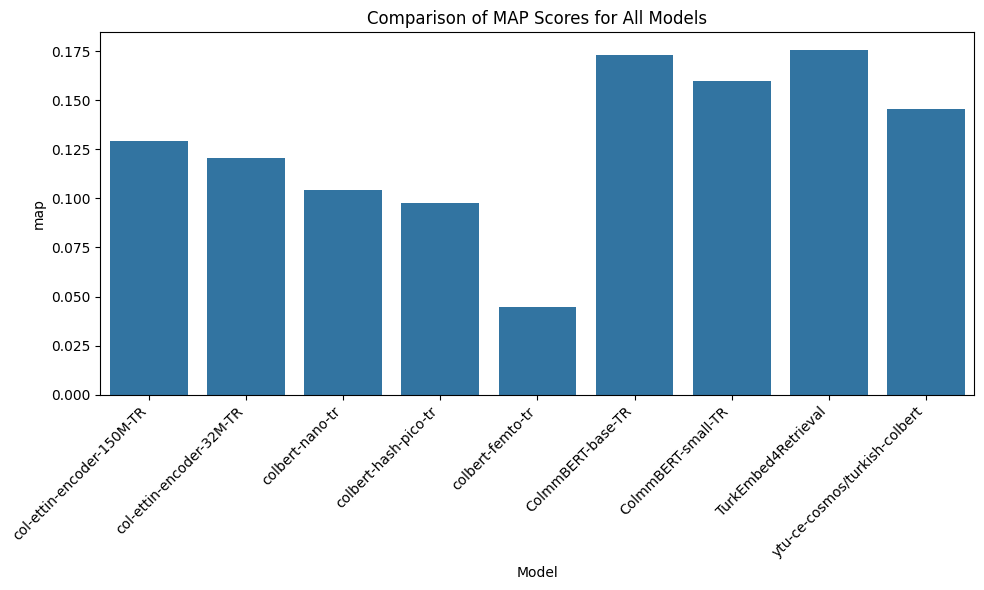

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='map', data=df)
plt.title('Comparison of MAP Scores for All Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ozayezerceli/ColmmBERT-small-TR",
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

modules.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/771 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/562M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

1_Dense/model.safetensors:   0%|          | 0.00/197k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:202: SyntaxWarning: invalid escape sequence '\c'
  + """\\begin{table*}[ht]\n\centering\n\caption{\nOverall effectiveness of the models.\nThe best results are highlighted in boldface.\nSuperscripts denote significant differences in """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:204: SyntaxWarning: invalid escape sequence '\l'
  + """ with $p \le """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:211: SyntaxWarning: invalid escape sequence '\#'
  + "\n\\textbf{\#}"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:216: SyntaxWarning: invalid escape sequence '\m'
  + " \\\\ \n\midrule"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:246: SyntaxWarning: invalid escape sequence '\e'
  "\\bottomrule\n\end{tabular}\n}\n\label{tab:results}\n\end{table*}"
/usr/local/lib/python3.12/dist-packages/ranx/metrics/ndcg.py:72: NumbaTypeS

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.1469177847033169), 'ndcg@5': np.float64(0.18526819388525145), 'ndcg@10': np.float64(0.22486304662494835), 'ndcg@100': np.float64(0.2858714236246463), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.2524893314366999), 'hits@5': np.float64(0.3456614509246088), 'hits@10': np.float64(0.46799431009957326), 'hits@100': np.float64(0.7588904694167852), 'map': np.float64(0.1601112313017649), 'recall@10': np.float64(0.46799431009957326), 'recall@100': np.float64(0.7588904694167852), 'precision@10': np.float64(0.04679943100995732), 'precision@100': np.float64(0.007588904694167852)}


#**TurkEmbed4Retrieval**

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="newmindai/TurkEmbed4Retrieval",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

configuration.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.012802275960170697), 'ndcg@3': np.float64(0.15410641254064666), 'ndcg@5': np.float64(0.1974459648458925), 'ndcg@10': np.float64(0.2446567125767366), 'ndcg@100': np.float64(0.3079948259007796), 'hits@1': np.float64(0.012802275960170697), 'hits@3': np.float64(0.2546230440967283), 'hits@5': np.float64(0.35988620199146515), 'hits@10': np.float64(0.5064011379800853), 'hits@100': np.float64(0.802275960170697), 'map': np.float64(0.1758823838458061), 'recall@10': np.float64(0.5064011379800853), 'recall@100': np.float64(0.802275960170697), 'precision@10': np.float64(0.05064011379800853), 'precision@100': np.float64(0.00802275960170697)}


#**ytu**-ce-cosmos/turkish-colbert

In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ytu-ce-cosmos/turkish-colbert",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

artifact.metadata: 0.00B [00:00, ?B/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

{'ndcg@1': np.float64(0.0), 'ndcg@3': np.float64(0.12493757588905097), 'ndcg@5': np.float64(0.1638382735592281), 'ndcg@10': np.float64(0.2071314772619379), 'ndcg@100': np.float64(0.2680853969350127), 'hits@1': np.float64(0.0), 'hits@3': np.float64(0.21337126600284495), 'hits@5': np.float64(0.3079658605974395), 'hits@10': np.float64(0.44096728307254623), 'hits@100': np.float64(0.7347083926031295), 'map': np.float64(0.14571665693698688), 'recall@10': np.float64(0.44096728307254623), 'recall@100': np.float64(0.7347083926031295), 'precision@10': np.float64(0.044096728307254626), 'precision@100': np.float64(0.007347083926031293)}


#**ytu**-ce-cosmos/turkish-e5-large


In [ ]:
# Sort the DataFrame by 'map' in descending order and display the top row
best_map_model = df.sort_values(by='map', ascending=False).head(1)
display(best_map_model)

,ndcg@1,ndcg@3,ndcg@5,ndcg@10,ndcg@100,hits@1,hits@3,hits@5,hits@10,hits@100,map,recall@10,recall@100,precision@10,precision@100
Model,,,,,,,,,,,,,,,
ytu-ce-cosmos/turkish-e5-large,0.019203,0.159796,0.203105,0.245863,0.305908,0.019203,0.259602,0.364865,0.497155,0.780228,0.179133,0.497155,0.780228,0.049716,0.007802


In [ ]:
"""Evaluation script for the trmteb/arguana-tr dataset."""

from __future__ import annotations
from datasets import load_dataset
from pylate import evaluation, indexes, models, retrieve


def _load_hf_information_retrieval_dataset(
    config: dict[str, str]
):
    """
    Loads the trmteb/arguana-tr dataset with:
      - name='corpus', split='corpus' → documents
      - name='queries', split='queries' → queries
      - name='default', split='test' → qrels
    """

    dataset_path = config["hf_dataset_path"]

    # Load splits
    corpus_split = load_dataset(dataset_path, name="corpus", split="corpus")
    queries_split = load_dataset(dataset_path, name="queries", split="queries")
    qrels_split = load_dataset(dataset_path, name="default", split="test")

    # Field mappings
    corpus_id_field = "_id"
    corpus_text_field = "text"
    query_id_field = "_id"
    query_text_field = "text"
    qrels_query_field = "query-id"
    qrels_doc_field = "corpus-id"
    qrels_score_field = "score"

    # Build corpus
    documents = [
        {"id": str(row[corpus_id_field]), "text": row[corpus_text_field]}
        for row in corpus_split
    ]

    # Build queries
    queries = {
        str(row[query_id_field]): row[query_text_field]
        for row in queries_split
    }

    # Build qrels
    qrels: dict[str, dict[str, float]] = {}
    for row in qrels_split:
        query_id = str(row[qrels_query_field])
        doc_id = str(row[qrels_doc_field])
        try:
            score_value = float(row[qrels_score_field])
        except (TypeError, ValueError):
            score_value = 1.0
        qrels.setdefault(query_id, {})[doc_id] = score_value

    return documents, queries, qrels


def run(dataset_name: str = "ArguAna-TR") -> dict[str, float]:
    config = {
        "dataset_name": dataset_name,
        "hf_dataset_path": "trmteb/arguana-tr",
        "query_length": None,
    }

    # Initialize ColBERT model
    model = models.ColBERT(
        model_name_or_path="ytu-ce-cosmos/turkish-e5-large",
        trust_remote_code=True,
        document_length=300,
        query_length=None,
    )
    index = indexes.PLAID(override=True)
    retriever = retrieve.ColBERT(index=index)

    # Load dataset
    documents, queries, qrels = _load_hf_information_retrieval_dataset(config)

    # Encode corpus
    documents_embeddings = model.encode(
        sentences=[doc["text"] for doc in documents],
        batch_size=128,
        is_query=False,
        show_progress_bar=True,
    )
    index.add_documents(
        documents_ids=[doc["id"] for doc in documents],
        documents_embeddings=documents_embeddings,
    )

    # Encode queries
    queries_embeddings = model.encode(
        sentences=list(queries.values()),
        batch_size=128,
        is_query=True,
        show_progress_bar=True,
    )

    # Retrieve and evaluate
    scores = retriever.retrieve(queries_embeddings=queries_embeddings, k=100)

    results = evaluation.evaluate(
        scores=scores,
        qrels=qrels,
        queries=list(queries.keys()),
        metrics=[
            f"ndcg@{k}" for k in [1, 3, 5, 10, 100]
        ]
        + [f"hits@{k}" for k in [1, 3, 5, 10, 100]]
        + ["map", "recall@10", "recall@100", "precision@10", "precision@100"],
    )

    return results


if __name__ == "__main__":
    metrics = run()
    print(metrics)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


README.md: 0.00B [00:00, ?B/s]

corpus/corpus-00000-of-00001.parquet:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/8674 [00:00<?, ? examples/s]

queries/queries-00000-of-00001.parquet:   0%|          | 0.00/949k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/1406 [00:00<?, ? examples/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1406 [00:00<?, ? examples/s]

Encoding documents (bs=128):   0%|          | 0/68 [00:00<?, ?it/s]

Encoding queries (bs=128):   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:202: SyntaxWarning: invalid escape sequence '\c'
  + """\\begin{table*}[ht]\n\centering\n\caption{\nOverall effectiveness of the models.\nThe best results are highlighted in boldface.\nSuperscripts denote significant differences in """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:204: SyntaxWarning: invalid escape sequence '\l'
  + """ with $p \le """
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:211: SyntaxWarning: invalid escape sequence '\#'
  + "\n\\textbf{\#}"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:216: SyntaxWarning: invalid escape sequence '\m'
  + " \\\\ \n\midrule"
/usr/local/lib/python3.12/dist-packages/ranx/data_structures/report.py:246: SyntaxWarning: invalid escape sequence '\e'
  "\\bottomrule\n\end{tabular}\n}\n\label{tab:results}\n\end{table*}"
/usr/local/lib/python3.12/dist-packages/ranx/metrics/ndcg.py:72: NumbaTypeS

{'ndcg@1': np.float64(0.019203413940256046), 'ndcg@3': np.float64(0.1597963129673892), 'ndcg@5': np.float64(0.20310469617531016), 'ndcg@10': np.float64(0.24586267633936687), 'ndcg@100': np.float64(0.3059083911202854), 'hits@1': np.float64(0.019203413940256046), 'hits@3': np.float64(0.259601706970128), 'hits@5': np.float64(0.36486486486486486), 'hits@10': np.float64(0.4971550497866287), 'hits@100': np.float64(0.7802275960170697), 'map': np.float64(0.1791329528385223), 'recall@10': np.float64(0.4971550497866287), 'recall@100': np.float64(0.7802275960170697), 'precision@10': np.float64(0.04971550497866288), 'precision@100': np.float64(0.007802275960170697)}
